# PART-1 : Exploratory Data Analysis

<div class="alert alert-success">

The <a href="https://www.cato.org/human-freedom-index/2021 ">Human Freedom Index</a> measures economic freedoms such as the freedom to trade or to use sound money, and it captures the degree to which people are free to enjoy the major freedoms often referred to as civil liberties—freedom of speech, religion, association, and assembly— in the countries in the survey. In addition, it includes indicators on rule of law, crime and violence, freedom of movement, and legal discrimination against same-sex relationships. We also include nine variables pertaining to women-specific freedoms that are found in various categories of the index.

<u>Citation</u>

Ian Vásquez, Fred McMahon, Ryan Murphy, and Guillermina Sutter Schneider, The Human Freedom Index 2021: A Global Measurement of Personal, Civil, and Economic Freedom (Washington: Cato Institute and the Fraser Institute, 2021).

In [1]:
import pandas as pd
import numpy as np

<div class="alert alert-info"></b>

Loading the Human Freedom Index data ```df```.

The data is laoded from the following URL https://raw.githubusercontent.com/kailaharsha/human-freedom-index/main/hfi.csv 

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/kailaharsha/human-freedom-index/main/hfi.csv')



<div class='alert alert-warning'>
    
The following columns are redundant and should be dropped:
* ```year```
* ```ISO```
* ```countries```
* All columns containing the word ```rank``` 
* All columns containing the word ```score```
    
</div>


# Steps involved in this part of the project

<font size="3"> The important step involved in PART-1 is to identify the correlated features in the feature matrix. For the identification of correlations between features, we make use of correlation matrix and remove features that a have a correlation above a certain threshold. It is important to note that we do not know the right thteshold at the start. We came up with a solution for this problem and the 2 broad steps involved in this solving this part are as follows :</font>

<font size="3">**Step-1** : In this step, we iterate across a range of values of threshold and plotted the training and test scores. Through this simple visualization, we arrive at a threshold that gives the maximum test score. </font>

<font size="3">**Step-2** : We run the final model by using the obtained threshold from Step-1 and by using the Correlation Matrix we remove correlated features if and only if the correlation between two of the features is greater than the decided threshold.</font>

## Step-1

100%|███████████████████████████████████████████| 25/25 [00:07<00:00,  3.50it/s]

THE OPTIMAL THRESHOLD VALUE IS : 0.965


Text(0.5, 1.0, 'Effect of training, test accuracies on the correlation threshold')

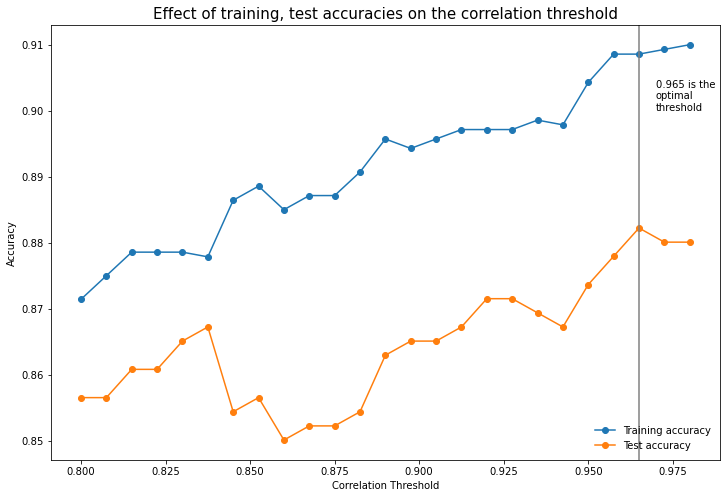

In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt

train_scores=[]
test_scores=[]

thresholds = np.linspace(0.80, 0.98, 25)


for threshold in tqdm(thresholds):

    #loading HFI data to a dataframe
    df=pd.read_csv('https://raw.githubusercontent.com/kailaharsha/human-freedom-index/main/hfi.csv')

    #Deleting redundant features 
    df = df.drop(['year', 'ISO', 'countries'], axis=1)

    cols = list(df.columns)

    del_cols=[]
    for col in cols : 
        if ("rank" in col) | ("score" in col) : 
            del_cols.append(col)

    #Deleting redundant features        
    df=df.drop(del_cols, axis=1)


    #Dropping all the rows where the target variable is missing 
    df = df[df['hf_quartile'].notna()]


    #Setting up the feature matrix and the target variable
    X=df.drop('hf_quartile', axis=1)
    y=df['hf_quartile']



    #Setting up the correlation matrix
    cor_matrix = X.corr().abs()

    #Extracting the upper triangular matrix
    upp_tri = np.triu(cor_matrix, 1)


    #Identifying the column indices of highly correlated features
    col_ind=[]
    for i in range(len(upp_tri)):
        for j in upp_tri[:,i] :
            if j>threshold:
                col_ind.append(i)
                break


    #Identifying the names of the redundant columns through indices & dropping them
    redundant_cols = []
    for index in col_ind : 
        redundant_cols.append(X.columns[index])


    X=X.drop(redundant_cols, axis=1)



                                ##Perform the train-test split##

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.75, test_size=0.25, random_state=0)



                                ##Defining the transformer##

    from sklearn.compose import ColumnTransformer

    #storing all the columns of feature matrix in this list
    cols=list(X.columns)

    #Applying impute on all features except "region" (as "region" doesn't have missing values)
    from sklearn.impute import SimpleImputer
    imp = SimpleImputer(strategy='mean')

    #Encoding the "region" variable using One Hot Encoder
    from sklearn.preprocessing import OneHotEncoder
    onehot_encoder = OneHotEncoder(sparse=False)


    #Defining the column transformer
    transformer=ColumnTransformer([ ('fill_na',imp,cols[1:]) , ('encoding',onehot_encoder,['region']) ],
                                  remainder='passthrough')



                                ##Other steps before setting up the pipeline##

    ##Instantiating MinMaxScaler class for Normalization
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()


    ##Instantiating LogisticRegression class for training the ML model
    ##Setting the solver for LogisticRegression as 'liblinear' for faster convergence
    from sklearn.linear_model import LogisticRegression
    lr=LogisticRegression(solver='liblinear')

    
                                ##Setting up the pipeline##

    from sklearn.pipeline import Pipeline

    pipeline_steps = [ ('data_cleaning', transformer), 
                     ('normalization', scaler),
                     ('Logistic_regression', lr )  ]


    pipe = Pipeline(pipeline_steps)


                                ##Training the model##
    pipe.fit(X_train, y_train)

                                #Storing the train and test scores##

    train_scores.append(pipe.score(X_train, y_train))
    test_scores.append(pipe.score(X_test, y_test))


#Finding the threshold at which we get the best training accuracy
optimal_threshold = thresholds[test_scores.index(max(test_scores))]
print("THE OPTIMAL THRESHOLD VALUE IS : {:.3f}".format(optimal_threshold))

#Visualizing training & test set accuracies using matplotlib
plt.figure(figsize=(12,8))
plt.plot(thresholds, train_scores, marker='o', label = "Training accuracy")
plt.plot(thresholds, test_scores, marker='o', label = "Test accuracy")
plt.xlabel("Correlation Threshold")
plt.ylabel("Accuracy")
ax=plt.gca()
ax.axvline(x=optimal_threshold, c='gray')
plt.text(0.97, 0.90, "0.965 is the\noptimal\nthreshold")
plt.legend(loc=4, frameon=False)
plt.title("Effect of training, test accuracies on the correlation threshold", fontsize=15)

## Step-2 : Reporting the best model 

In [5]:
#loading HFI data to a dataframe
df=pd.read_csv('https://raw.githubusercontent.com/kailaharsha/human-freedom-index/main/hfi.csv')

#Deleting redundant features 
df = df.drop(['year', 'ISO', 'countries'], axis=1)

cols = list(df.columns)

del_cols=[]
for col in cols : 
    if ("rank" in col) | ("score" in col) : 
        del_cols.append(col)

#Deleting redundant features        
df=df.drop(del_cols, axis=1)


#Dropping all the rows where the target variable is missing 
df = df[df['hf_quartile'].notna()]


#Setting up the feature matrix and the target variable
X=df.drop('hf_quartile', axis=1)
y=df['hf_quartile']



#Setting up the correlation matrix
cor_matrix = X.corr().abs()

#Extracting the upper triangular matrix
upp_tri = np.triu(cor_matrix, 1)


#Identifying the column indices of highly correlated features using optimal threshold from Step-1

col_ind=[]
for i in range(len(upp_tri)):
    for j in upp_tri[:,i] :
        if j>optimal_threshold:
            col_ind.append(i)
            break


#Identifying the names of the redundant columns through indices & dropping them
redundant_cols = []
for index in col_ind : 
    redundant_cols.append(X.columns[index])


X=X.drop(redundant_cols, axis=1)
print("The dropped columns are : ", redundant_cols)
print("\n")


print("The accuracy of the model is : {:.3f}".format(max(test_scores)))

The dropped columns are :  ['pf_assembly_parties_auton', 'pf_identity_inheritance_daughters', 'pf_identity']


The accuracy of the model is : 0.882
